# Plotting with Uncertainties and Regression

This is a rough attempt to produce plots of SuperWASP light curves which show uncertainties and fit a curve to the data. For now this uses seaborn's regplot method until I have time to find something better (i.e. something that takes the uncertainties into account).

In [1]:
from astropy import units as u
import astropy.io.fits as fits
from astropy.table import vstack
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clip

from matplotlib import pyplot

import pandas
import seaborn
import numpy

[VeSPA data exports can be downloaded here](https://www.superwasp.org/vespa/).

In [2]:
vespa = pandas.read_csv('../../superwasp-data/vespa-export.csv')
vespa.head()

,SuperWASP ID,Period Length,RA,Dec,Maximum magnitude,Minimum magnitude,Mean magnitude,Amplitude,Classification,Classification count,Folding flag,Sigma,Chi squared,FITS URL,JSON URL,Unfolded plot URL,Folded plot URL
0,1SWASPJ000126.73-001344.2,24007.58594,0h01m26.73s,-0d13m44.2s,14.023840,21.350196,14.870849,7.326356,Pulsator,4,Uncertain,6.22,37.37,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...
1,1SWASPJ000236.45+002446.3,20553.37500,0h02m36.45s,0d24m46.3s,13.998806,16.670559,14.678380,2.671753,EA/EB,7,Uncertain,5.88,30.41,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...
2,1SWASPJ000236.45+002446.3,16595.36914,0h02m36.45s,0d24m46.3s,13.998806,16.670559,14.678380,2.671753,EW,7,Certain,4.51,21.07,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...
3,1SWASPJ000236.45+002446.3,27404.40430,0h02m36.45s,0d24m46.3s,13.998806,16.670559,14.678380,2.671753,EW,4,Certain,4.90,25.00,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...
4,1SWASPJ000236.20+002516.3,27404.29492,0h02m36.2s,0d25m16.3s,14.079385,17.870184,14.824788,3.790799,EA/EB,5,Certain,4.54,21.15,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...,https://www.superwasp.org/media/sources/1SWASP...


In [3]:
vespa = vespa[(vespa['Classification'] == 'Pulsator') & (vespa['Folding flag'] == 'Certain')]

In [4]:
row = vespa.iloc[5]

In [5]:
fits_file = fits.open(row['FITS URL'])
hjd_col = fits.Column(name='HJD', format='D', array=fits_file[1].data['TMID'] / 86400 + 2453005.5)
lc_data = fits.BinTableHDU.from_columns(fits_file[1].data.columns + fits.ColDefs([hjd_col]))
timeseries = TimeSeries.read(lc_data, time_column='HJD', time_format='jd').fold(period=row['Period Length'] * u.second)

Change this to `True` if you want to plot two epochs instead of one.

In [6]:
if False:
    epoch_length = timeseries['time'].max() - timeseries['time'].min()
    ts_out = [timeseries]
    ts_new = timeseries.copy()
    ts_new['time'] = ts_new['time'] + epoch_length
    ts_out.append(ts_new)
    timeseries = vstack(ts_out)

Swap these if you don't want to clip the data.

In [7]:
ts_flux = sigma_clip(timeseries['TAMFLUX2'], sigma=4)
#ts_flux = timeseries['TAMFLUX2']

In [8]:
ts_data = {
    'time': timeseries.time.jd,
    'flux': ts_flux,
    'err': timeseries['TAMFLUX2_ERR'],
    'camera': timeseries['CAMERA_ID'],
}

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order, subok=True)


(2.6243764996528625, 5.488460576534271)

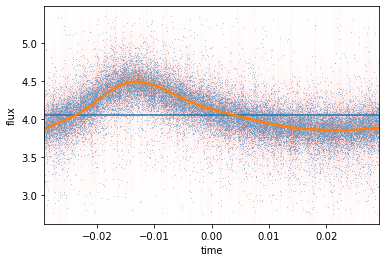

In [9]:
fig = pyplot.figure()
seaborn.scatterplot(
    data=ts_data,
    x='time',
    y='flux',
    alpha=0.5,
    s=1,
    palette='Set2',
)
lims = pyplot.ylim()
pyplot.axhline(numpy.median(ts_flux))

pyplot.errorbar(ts_data['time'], ts_data['flux'], yerr=ts_data['err'], ecolor='red', ls='none', zorder=-1, alpha=0.1, elinewidth=0.1)
seaborn.regplot(
    data=ts_data,
    x='time',
    y='flux',
    scatter=False,
    order=12,
)

pyplot.ylim(lims)